In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Concatenate, Add, Average, Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
import numpy as np
import os
import time
import cv2
from imutils import paths
import skimage.measure
from google.colab.patches import cv2_imshow
import math

In [ ]:
import tensorflow as tf
def PSNR(y_true,y_pred):
  return tf.image.psnr(y_true, y_pred, max_val=255)

In [ ]:
lr_path = '/content/drive/Shareddrives/PMAT/Datasets/LR/Valid'
lr_images = list(paths.list_images(lr_path))

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, data_dir, mode='fit', batch_size=8,dim=(256, 256),scale=0.5, channels=3, shuffle=True):
        self.list_image = list(paths.list_images(data_dir))
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.scale=scale
        self.channels = channels
        self.shuffle = shuffle
        self.on_epoch_end()
   
    # phương thức này sẽ được tự đông gọi khi kết thúc 1 epoch, để đảo ngẫu nhiên lại thứ tự các ảnh khi train
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_image))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    # trả về số lượng batch
    def __len__(self):
        return int(np.floor(len(self.list_image) / self.batch_size))
    
    # trả về batch tương ứng với index
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
        if self.mode == 'fit':
            # các train data của batch đó sẽ được lưu vào biến X
            X = np.empty((self.batch_size, *(self.dim), self.channels))
            # nếu model đang train thì cần tạo thêm dữ liệu về ảnh gốc của batch đó
            y = np.empty((self.batch_size, *self.dim, self.channels))
            for i, ID in enumerate(batch_indexes):
                img = cv2.imread(self.list_image[ID])
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
                y[i]=img

                # giảm độ phân giải hình ảnh bẳng cách dùng avg pooling theo đúng scale
                pooling_size = int(1/self.scale)
                img = skimage.measure.block_reduce(img, (pooling_size,pooling_size,1), np.mean)

                # xong lại upscale theo phương pháp bicubic interpolation
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
                X[i] = img

            return X,y
                
                
        # nếu model đang predict thì không cần tạo thêm dữ liệu về ảnh gốc của batch đó
        elif self.mode == 'predict':
            X = np.empty((self.batch_size, *(self.dim), self.channels))
            for i, ID in enumerate(batch_indexes):
                img = cv2.imread(self.list_image[ID])
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)

                # giảm độ phân giải hình ảnh bẳng cách dùng avg pooling theo đúng scale
                pooling_size = int(1/self.scale)
                img = skimage.measure.block_reduce(img, (pooling_size,pooling_size,1), np.mean)

                # xong lại upscale theo phương pháp bicubic interpolation
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
                X[i] = img
            return X
        
        else:
            raise AttributeError("The mode should be set to either 'fit' or 'predict'.")
            

In [ ]:
train_data_generator= DataGenerator('/content/drive/Shareddrives/PMAT/Datasets/HR/Train')
val_data_generator= DataGenerator('/content/drive/Shareddrives/PMAT/Datasets/HR/Valid')

In [ ]:
def SRCNN(height=256, width=256, channels=3, load_weights=False, batch_size=128):
  X_input = Input(shape=(height,width,channels))
  X = Conv2D(64, (9,9), activation = 'relu', padding = 'same')(X_input)
  X = BatchNormalization(axis = 3)(X)
  X = Conv2D(32, (1,1), activation = 'relu', padding = 'same')(X)
  X = BatchNormalization(axis = 3)(X)
  out = Conv2D(3,(5,5), activation = 'linear', padding = 'same')(X)
  model = Model(inputs = X_input, outputs = out, name = 'SRCNN')
  return model

In [ ]:
def resnet_lite(height=256, width=256, channels=3, load_weights=False, batch_size=128):
  X_input = Input(shape=(height,width,channels))
  X0 = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(X_input)
  x = Conv2D(32, (3,3), activation = 'linear', padding = 'same')(X0)
  x = BatchNormalization(axis = 3)(x)
  x = Activation('relu')(x)
  x = Conv2D(32, (3,3), activation = 'linear', padding = 'same')(x)
  x = BatchNormalization(axis = 3)(x)
  x = Add()([x,X0])
  x = Add()([x,X0])
  x = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(x)
  out = Conv2D(3, (3,3), activation = 'linear', padding = 'same')(x)
  model = Model(inputs = X_input, outputs = out, name = 'resnetSR')
  return model

In [ ]:
def residual_block(ip, id):
    init = ip

    x = Conv2D(64, (3, 3), activation='linear', padding='same',
                      name='sr_res_conv_' + str(id) + '_1')(ip)
    x = BatchNormalization( name="sr_res_batchnorm_" + str(id) + "_1")(x, training=True)
    x = Activation('relu', name="sr_res_activation_" + str(id) + "_1")(x)

    x = Conv2D(64, (3, 3), activation='linear', padding='same',
                      name='sr_res_conv_' + str(id) + '_2')(x)
    x = BatchNormalization( name="sr_res_batchnorm_" + str(id) + "_2")(x, training=True)

    m = Add(name="sr_res_merge_" + str(id))([x, init])

    return m

def resnet(height=256, width=256, channels=3, load_weights=False, batch_size=128):
    init= Input(shape=(height,width,channels))

    x0 = Conv2D(64, (3, 3), activation='relu', padding='same', name='sr_res_conv1')(init)

    x = residual_block(x0, 1)

    nb_residual = 5
    for i in range(nb_residual):
        x = residual_block(x, i + 2)

    x = Add()([x, x0])
    x = Conv2D(3, (3, 3), activation="linear", padding='same', name='sr_res_conv_final')(x)

    model = Model(init, x)
    return model


In [ ]:
def Auto_Encoder(height=256, width=256, channels=3, load_weights=False, batch_size=128):
  X_input = Input(shape=(height,width,channels))  
  #encoding architecture
  x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(X_input)
  x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
  x3 = MaxPooling2D(padding='same')(x2)
  x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
  x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
  x6 = MaxPooling2D(padding='same')(x5)
  encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
  # decoding architecture
  x7 = Conv2DTranspose(256, (3,3), padding = 'same', strides = (2,2), kernel_initializer='he_uniform', activation='relu', activity_regularizer = regularizers.l1(10e-10))(encoded)
  x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
  x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
  x10 = Add()([x5, x9])
  x11 = Conv2DTranspose(128, (3,3), padding = 'same', strides = (2,2), kernel_initializer='he_uniform', activation='relu', activity_regularizer = regularizers.l1(10e-10))(x10)
  x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
  x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
  x14 = Add()([x2, x13])
  decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)
  model = Model(inputs = X_input, outputs = decoded, name = 'AESR')
  return model


In [ ]:
SRCNN_time = []
for path_ in lr_images:
  lr = cv2.imread(path_)
  h = math.floor((lr.shape[1]*2)/4)*4
  w = math.floor((lr.shape[0]*2)/4)*4
  img= cv2.resize(lr, (h,w),interpolation=cv2.INTER_CUBIC )
  model_srcnn = SRCNN(img.shape[0], img.shape[1])
  model_srcnn.load_weights('/content/drive/Shareddrives/PMAT/Final/weights/srcnn.h5')
  img_ = img.reshape(1,*img.shape)
  start = time.time()
  img_srcnn= model_srcnn.predict(img_)[0]
  SRCNN_time.append(float(time.time()-start))
srcnn_fps = len(SRCNN_time)/sum(SRCNN_time)
print(f"FPS SRCNN: {srcnn_fps}")

FPS SRCNN: 8.810778014505052


In [ ]:
ResNet_time = []
for path_ in lr_images:
  lr = cv2.imread(path_)
  h = math.floor((lr.shape[1]*2)/4)*4
  w = math.floor((lr.shape[0]*2)/4)*4
  img= cv2.resize(lr, (h,w),interpolation=cv2.INTER_CUBIC )
  model_resnet = resnet(img.shape[0], img.shape[1])
  model_resnet.load_weights('/content/drive/Shareddrives/PMAT/Final/weights/resnet.h5')
  img_ = img.reshape(1,*img.shape)
  start = time.time()
  img_lite= model_resnet.predict(img_)[0]
  ResNet_time.append(float(time.time()-start))
resnet_fps = len(ResNet_time)/sum(ResNet_time)
print(f"FPS ResNet: {resnet_fps}")

FPS ResNet: 2.581117952793322


In [ ]:
ResNet_lite_time = []
for path_ in lr_images:
  lr = cv2.imread(path_)
  h = math.floor((lr.shape[1]*2)/4)*4
  w = math.floor((lr.shape[0]*2)/4)*4
  img= cv2.resize(lr, (h,w),interpolation=cv2.INTER_CUBIC )
  model_resnet_lite = resnet_lite(img.shape[0], img.shape[1])
  model_resnet_lite.load_weights('/content/drive/Shareddrives/PMAT/Final/weights/resnetSR(lite).h5')
  img_ = img.reshape(1,*img.shape)
  start = time.time()
  img_lite= model_resnet_lite.predict(img_)[0]
  ResNet_lite_time.append(float(time.time()-start))
resnet_lite_fps = len(ResNet_lite_time)/sum(ResNet_lite_time)
print(f"FPS ResNet Lite: {resnet_lite_fps}")

FPS ResNet Lite: 7.702463889925848


In [ ]:
AE_time = []
for path_ in lr_images:
  lr = cv2.imread(path_)
  h = math.floor((lr.shape[1]*2)/4)*4
  w = math.floor((lr.shape[0]*2)/4)*4
  img= cv2.resize(lr, (h,w),interpolation=cv2.INTER_CUBIC )
  model_AE = Auto_Encoder(img.shape[0], img.shape[1])
  model_AE.load_weights('/content/drive/Shareddrives/PMAT/Final/weights/AE.h5')
  img_ = img.reshape(1,*img.shape)
  start = time.time()
  img_ae= model_AE.predict(img_)[0]
  AE_time.append(float(time.time()-start))
ae_fps = len(AE_time)/sum(AE_time)
print(f"FPS AE: {ae_fps}")

FPS AE: 3.936475779824184


In [ ]:
%cd /content/drive/Shareddrives/PMAT/Image_demo

/content/drive/Shareddrives/PMAT/Image_demo


In [ ]:
!ls

0829.png  0829x8.png  0850.png	0850x8.png  0855.png  0855x8.png  download.jpeg


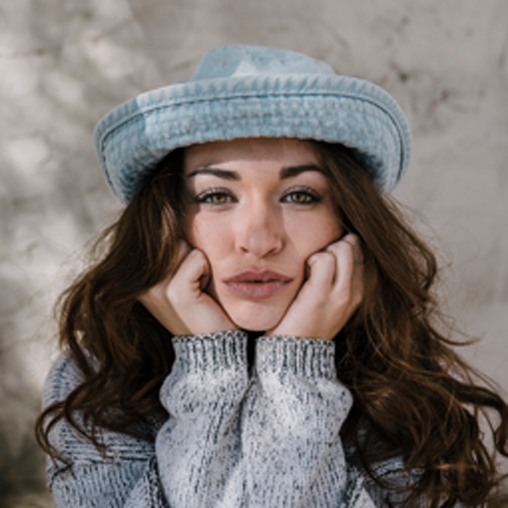

In [ ]:
hr = cv2.imread('0829.png')
lr = cv2.imread('0855x8.png')
h = math.floor((lr.shape[1]*2)/4)*4
w = math.floor((lr.shape[0]*2)/4)*4
img= cv2.resize(lr, (h,w),interpolation=cv2.INTER_CUBIC )
cv2_imshow(img)

In [ ]:
img_ = img.reshape(1,*img.shape)

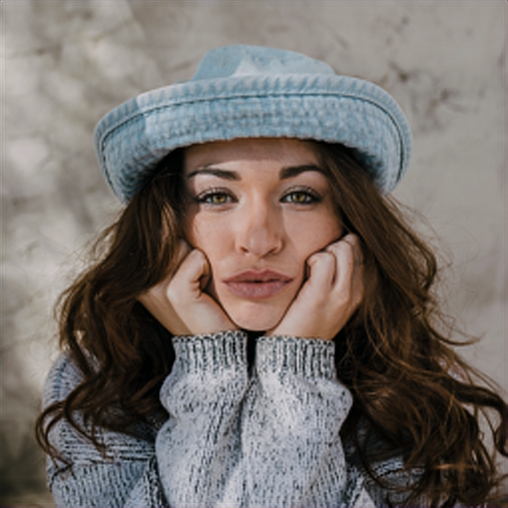

In [ ]:
model_srcnn = SRCNN(img.shape[0], img.shape[1])
model_srcnn.load_weights('/content/drive/Shareddrives/PMAT/Final/weights/srcnn.h5')
img_srcnn= model_srcnn.predict(img_)[0]
cv2_imshow(img_srcnn)

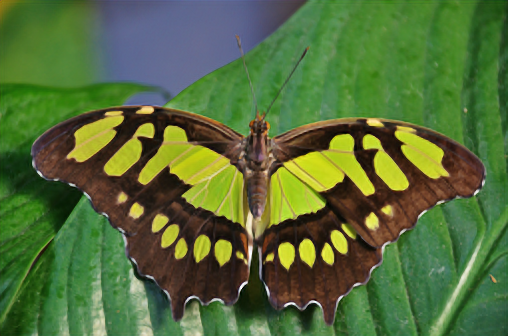

In [ ]:
model_resnet = resnet(img.shape[0], img.shape[1])
model_resnet.load_weights('/content/drive/Shareddrives/PMAT/Final/weights/resnet.h5')
img_resnet= model_resnet.predict(img_)[0]
cv2_imshow(img_resnet)

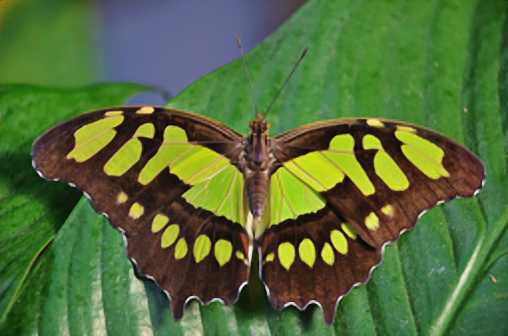

In [ ]:
model_resnet_lite = resnet_lite(img.shape[0], img.shape[1])
model_resnet_lite.load_weights('/content/drive/Shareddrives/PMAT/Final/weights/resnetSR(lite).h5')
img_resnet_lite= model_resnet_lite.predict(img_)[0]
cv2_imshow(img_resnet_lite)

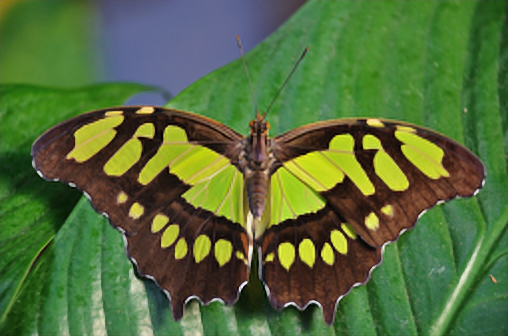

In [ ]:
model_AE = Auto_Encoder(img.shape[0], img.shape[1])
model_AE.load_weights('/content/drive/Shareddrives/PMAT/Final/weights/AE.h5')
img_AE= model_AE.predict(img_)[0]
cv2_imshow(img_AE)

In [ ]:
model_srcnn = load_model('/content/drive/Shareddrives/PMAT/Final/weights/srcnn.h5')
model_resnet = load_model('/content/drive/Shareddrives/PMAT/Final/weights/resnet.h5')
model_resnet_lite = load_model('/content/drive/Shareddrives/PMAT/Final/weights/resnetSR(lite).h5')
model_AE = load_model('/content/drive/Shareddrives/PMAT/Final/weights/AE.h5')

In [ ]:
model_srcnn.compile(loss='mse',metrics=[PSNR])
model_srcnn.evaluate(val_data_generator)

12/12 [==============================] - 10s 793ms/step - loss: 506.3407 - PSNR: 21.9442


[506.3406677246094, 21.9442195892334]

In [ ]:
model_resnet.compile(loss='mse',metrics=[PSNR])
model_resnet.evaluate(val_data_generator)

12/12 [==============================] - 10s 818ms/step - loss: 392.0870 - PSNR: 23.3706


[392.0870056152344, 23.370622634887695]

In [ ]:
model_resnet_lite.compile(loss='mse',metrics=[PSNR])
model_resnet_lite.evaluate(val_data_generator)

12/12 [==============================] - 10s 793ms/step - loss: 410.2765 - PSNR: 23.1056


[410.2764892578125, 23.10560417175293]

In [ ]:
model_AE.compile(loss='mse',metrics=[PSNR])
model_AE.evaluate(val_data_generator)

12/12 [==============================] - 13s 1s/step - loss: 401.5461 - PSNR: 23.1817


[401.5460510253906, 23.18165397644043]